# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [10]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

import helper
 
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [9]:


#!pip install --upgrade --force-reinstall matplotlib==2.0.0
!pip install --upgrade --force-reinstall tqdm==4.11.2
#!pip install --upgrade numpy
from google.colab import files
files.upload()
import helper
import problem_unittests
# choose the file on your computer to upload it then


  Using cached https://files.pythonhosted.org/packages/b7/0d/174388e99e21ee2c91ea318994c3f8744e26158e43cff0ec9d045bf08a96/tqdm-4.11.2-py2.py3-none-any.whl
  Found existing installation: tqdm 4.11.2
    Uninstalling tqdm-4.11.2:
      Successfully uninstalled tqdm-4.11.2


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

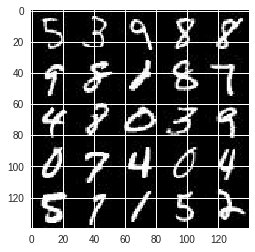

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

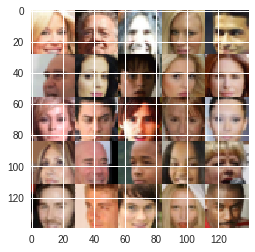

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name="input_real")
    inputs_z=tf.placeholder(tf.float32,[None,z_dim],name="input_z")
    learning_rate=tf.placeholder(tf.float32,[],name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator",reuse=reuse):
        x1=tf.layers.conv2d(images,64,5, strides=2,padding="same")
        x1=tf.maximum(x1*alpha,x1)
        #layer2
        x2=tf.layers.conv2d(x1,128,5 ,strides=2,padding="same")
        x2=tf.layers.batch_normalization(x2, training=True)
        x2=tf.maximum(x2*alpha,x2)

        #layer3
        x3=tf.layers.conv2d(x2,256,5 ,strides=2,padding="same")
        x3=tf.layers.batch_normalization(x3, training=True)
        x3=tf.maximum(x3*alpha,x3)

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)



    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not (is_train)):
        
        x1=tf.layers.dense(z,7*7*512)
        x1=tf.reshape(x1,[-1,7,7,512])
        x1= tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        #conv1
        x2=tf.layers.conv2d_transpose(x1,265,5,strides=2,padding='same')
        x2= tf.layers.batch_normalization(x2, training=True)
        x2= tf.maximum(alpha * x2, x2)
        

        #output layer
        logits=tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z, out_channel_dim, is_train=True)
    d_real_out,d_real_logits=discriminator(input_real, reuse=False)
    d_fake_out,d_fake_logits=discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_out)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_out)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_out)))

    d_loss = d_loss_real + d_loss_fake
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    input_real,input_z,lr=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(input_real, input_z, data_shape[3])
    d_train_opt,g_train_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    steps=0
    losses =[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))   
    
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,input_real: batch_images,lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 12, input_z, data_shape[3], data_image_mode)
# Save training generator samples
#with open('train_samples.pkl', 'wb') as f:
    #pkl.dump(samples, f)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 0.9829... Generator Loss: 0.8523
Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 1.0080
Epoch 1/2... Discriminator Loss: 0.8788... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 0.8350... Generator Loss: 1.1402


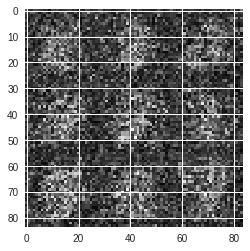

Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 0.9352
Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 1.1500
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.1696
Epoch 1/2... Discriminator Loss: 0.6556... Generator Loss: 1.1723
Epoch 1/2... Discriminator Loss: 0.6440... Generator Loss: 1.2275
Epoch 1/2... Discriminator Loss: 0.7098... Generator Loss: 1.1553
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 1.4479
Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 1.3555
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 1.3425


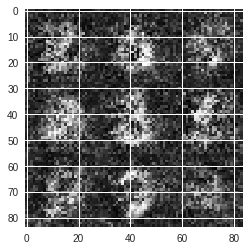

Epoch 1/2... Discriminator Loss: 0.5239... Generator Loss: 1.4046
Epoch 1/2... Discriminator Loss: 0.6079... Generator Loss: 1.2592
Epoch 1/2... Discriminator Loss: 0.6389... Generator Loss: 1.3713
Epoch 1/2... Discriminator Loss: 0.7341... Generator Loss: 1.1647
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 1.5231
Epoch 1/2... Discriminator Loss: 0.6004... Generator Loss: 1.3713
Epoch 1/2... Discriminator Loss: 0.6484... Generator Loss: 1.3064
Epoch 1/2... Discriminator Loss: 0.6582... Generator Loss: 1.2864
Epoch 1/2... Discriminator Loss: 0.6077... Generator Loss: 1.2174
Epoch 1/2... Discriminator Loss: 0.5077... Generator Loss: 1.5542


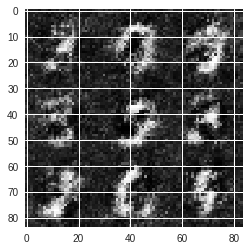

Epoch 1/2... Discriminator Loss: 0.5560... Generator Loss: 1.4933
Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 1.4570
Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 1.4112
Epoch 1/2... Discriminator Loss: 0.4270... Generator Loss: 1.8497
Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 1.7623
Epoch 1/2... Discriminator Loss: 0.5130... Generator Loss: 1.5137
Epoch 1/2... Discriminator Loss: 0.4885... Generator Loss: 1.6571
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 1.6031
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 1.4362
Epoch 1/2... Discriminator Loss: 0.4740... Generator Loss: 1.5214


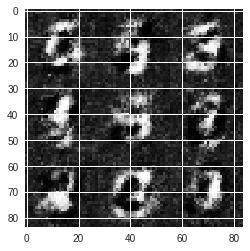

Epoch 1/2... Discriminator Loss: 0.4531... Generator Loss: 1.4716
Epoch 1/2... Discriminator Loss: 0.4223... Generator Loss: 1.6931
Epoch 1/2... Discriminator Loss: 0.4435... Generator Loss: 1.4964
Epoch 1/2... Discriminator Loss: 0.4299... Generator Loss: 1.6420
Epoch 1/2... Discriminator Loss: 0.3493... Generator Loss: 1.9195
Epoch 1/2... Discriminator Loss: 0.2716... Generator Loss: 2.2018
Epoch 1/2... Discriminator Loss: 0.3294... Generator Loss: 1.7773
Epoch 1/2... Discriminator Loss: 0.4260... Generator Loss: 1.4104
Epoch 1/2... Discriminator Loss: 0.2991... Generator Loss: 1.8637
Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 1.8121


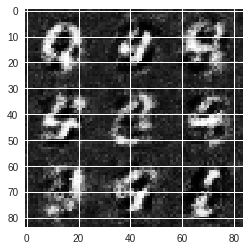

Epoch 1/2... Discriminator Loss: 0.2275... Generator Loss: 2.1887
Epoch 1/2... Discriminator Loss: 0.2587... Generator Loss: 2.0581
Epoch 1/2... Discriminator Loss: 0.3002... Generator Loss: 2.0152
Epoch 1/2... Discriminator Loss: 0.2996... Generator Loss: 1.9074
Epoch 1/2... Discriminator Loss: 0.1885... Generator Loss: 2.4346
Epoch 1/2... Discriminator Loss: 0.2565... Generator Loss: 2.1452
Epoch 1/2... Discriminator Loss: 0.2401... Generator Loss: 2.2181
Epoch 1/2... Discriminator Loss: 0.2185... Generator Loss: 2.2426
Epoch 1/2... Discriminator Loss: 0.1656... Generator Loss: 2.4969
Epoch 1/2... Discriminator Loss: 0.1590... Generator Loss: 2.8304


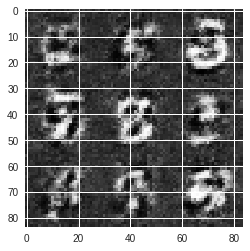

Epoch 1/2... Discriminator Loss: 0.1743... Generator Loss: 2.5303
Epoch 1/2... Discriminator Loss: 0.1674... Generator Loss: 2.5681
Epoch 1/2... Discriminator Loss: 0.2075... Generator Loss: 2.2456
Epoch 1/2... Discriminator Loss: 0.2431... Generator Loss: 1.9768
Epoch 1/2... Discriminator Loss: 0.2045... Generator Loss: 2.5009
Epoch 1/2... Discriminator Loss: 0.2657... Generator Loss: 2.2153
Epoch 1/2... Discriminator Loss: 0.3609... Generator Loss: 1.6239
Epoch 1/2... Discriminator Loss: 0.1873... Generator Loss: 2.5340
Epoch 1/2... Discriminator Loss: 0.4281... Generator Loss: 1.3718
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 1.1705


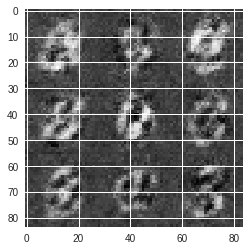

Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 1.7070
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 1.2270
Epoch 1/2... Discriminator Loss: 0.3278... Generator Loss: 1.7859
Epoch 1/2... Discriminator Loss: 0.4085... Generator Loss: 1.3520
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 1.8854
Epoch 1/2... Discriminator Loss: 0.4808... Generator Loss: 1.4648
Epoch 1/2... Discriminator Loss: 0.2267... Generator Loss: 2.4418
Epoch 1/2... Discriminator Loss: 0.2891... Generator Loss: 1.7688
Epoch 1/2... Discriminator Loss: 0.3099... Generator Loss: 2.1001
Epoch 1/2... Discriminator Loss: 0.2076... Generator Loss: 2.4077


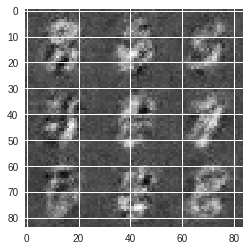

Epoch 1/2... Discriminator Loss: 0.2684... Generator Loss: 1.9650
Epoch 1/2... Discriminator Loss: 0.2545... Generator Loss: 2.4823
Epoch 1/2... Discriminator Loss: 0.2970... Generator Loss: 1.8017
Epoch 1/2... Discriminator Loss: 0.2031... Generator Loss: 2.7169
Epoch 1/2... Discriminator Loss: 0.3352... Generator Loss: 1.6790
Epoch 1/2... Discriminator Loss: 0.1773... Generator Loss: 2.3864
Epoch 1/2... Discriminator Loss: 0.1385... Generator Loss: 3.0827
Epoch 1/2... Discriminator Loss: 0.2502... Generator Loss: 2.1392
Epoch 1/2... Discriminator Loss: 0.2887... Generator Loss: 1.6872
Epoch 1/2... Discriminator Loss: 0.2050... Generator Loss: 2.5822


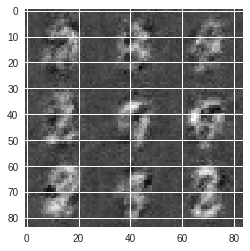

Epoch 1/2... Discriminator Loss: 0.2297... Generator Loss: 2.0961
Epoch 1/2... Discriminator Loss: 0.1800... Generator Loss: 2.3110
Epoch 1/2... Discriminator Loss: 0.1967... Generator Loss: 2.4756
Epoch 1/2... Discriminator Loss: 0.1290... Generator Loss: 3.0264
Epoch 1/2... Discriminator Loss: 0.1638... Generator Loss: 2.5828
Epoch 1/2... Discriminator Loss: 0.1579... Generator Loss: 2.6901
Epoch 1/2... Discriminator Loss: 0.1348... Generator Loss: 3.2182
Epoch 1/2... Discriminator Loss: 0.1688... Generator Loss: 2.3184
Epoch 1/2... Discriminator Loss: 0.2415... Generator Loss: 1.8978
Epoch 1/2... Discriminator Loss: 0.1450... Generator Loss: 3.2745


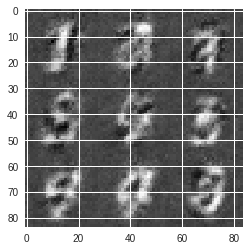

Epoch 1/2... Discriminator Loss: 0.1237... Generator Loss: 2.8048
Epoch 1/2... Discriminator Loss: 0.1309... Generator Loss: 2.5406
Epoch 1/2... Discriminator Loss: 0.1571... Generator Loss: 2.6212
Epoch 1/2... Discriminator Loss: 0.2374... Generator Loss: 2.3445
Epoch 1/2... Discriminator Loss: 0.1590... Generator Loss: 2.7164
Epoch 1/2... Discriminator Loss: 0.1499... Generator Loss: 2.8182
Epoch 1/2... Discriminator Loss: 0.1274... Generator Loss: 2.9088
Epoch 1/2... Discriminator Loss: 0.1674... Generator Loss: 2.3693
Epoch 1/2... Discriminator Loss: 0.1479... Generator Loss: 2.8829
Epoch 1/2... Discriminator Loss: 0.0926... Generator Loss: 3.4051


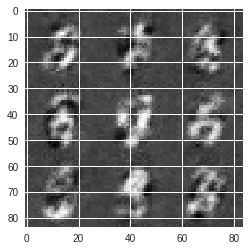

Epoch 1/2... Discriminator Loss: 0.1426... Generator Loss: 2.7842
Epoch 1/2... Discriminator Loss: 0.1006... Generator Loss: 3.4107
Epoch 1/2... Discriminator Loss: 0.1041... Generator Loss: 2.9492
Epoch 1/2... Discriminator Loss: 0.1267... Generator Loss: 2.9770
Epoch 1/2... Discriminator Loss: 0.2286... Generator Loss: 2.0248
Epoch 1/2... Discriminator Loss: 0.0838... Generator Loss: 3.4389
Epoch 1/2... Discriminator Loss: 0.1385... Generator Loss: 3.1385
Epoch 1/2... Discriminator Loss: 0.0734... Generator Loss: 3.6534
Epoch 1/2... Discriminator Loss: 0.1218... Generator Loss: 2.9064
Epoch 1/2... Discriminator Loss: 0.0920... Generator Loss: 3.0827


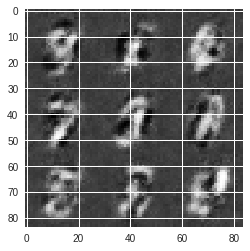

Epoch 1/2... Discriminator Loss: 0.0766... Generator Loss: 3.9782
Epoch 1/2... Discriminator Loss: 0.1334... Generator Loss: 2.7631
Epoch 1/2... Discriminator Loss: 0.1018... Generator Loss: 3.1661
Epoch 1/2... Discriminator Loss: 0.1060... Generator Loss: 2.8570
Epoch 1/2... Discriminator Loss: 0.1215... Generator Loss: 3.4246
Epoch 1/2... Discriminator Loss: 0.1071... Generator Loss: 3.0739
Epoch 1/2... Discriminator Loss: 0.1669... Generator Loss: 2.5474
Epoch 1/2... Discriminator Loss: 0.1024... Generator Loss: 3.0902
Epoch 1/2... Discriminator Loss: 0.1046... Generator Loss: 3.4612
Epoch 1/2... Discriminator Loss: 0.0749... Generator Loss: 3.6757


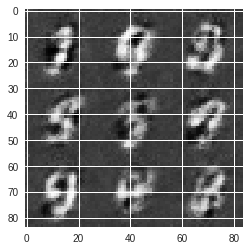

Epoch 1/2... Discriminator Loss: 0.1005... Generator Loss: 3.0545
Epoch 1/2... Discriminator Loss: 0.1035... Generator Loss: 3.6171
Epoch 1/2... Discriminator Loss: 0.0553... Generator Loss: 4.0589
Epoch 1/2... Discriminator Loss: 0.0763... Generator Loss: 3.9902
Epoch 1/2... Discriminator Loss: 0.0742... Generator Loss: 3.9778
Epoch 1/2... Discriminator Loss: 0.0718... Generator Loss: 3.3181
Epoch 1/2... Discriminator Loss: 0.0925... Generator Loss: 3.3813
Epoch 1/2... Discriminator Loss: 0.1480... Generator Loss: 3.7740
Epoch 1/2... Discriminator Loss: 0.0765... Generator Loss: 3.4629
Epoch 1/2... Discriminator Loss: 0.1533... Generator Loss: 2.5439


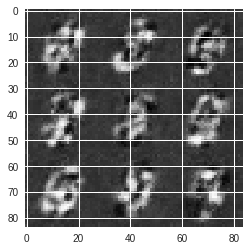

Epoch 1/2... Discriminator Loss: 0.1392... Generator Loss: 3.4342
Epoch 1/2... Discriminator Loss: 0.0726... Generator Loss: 3.6192
Epoch 1/2... Discriminator Loss: 0.1171... Generator Loss: 3.3205
Epoch 1/2... Discriminator Loss: 0.0565... Generator Loss: 3.9743
Epoch 1/2... Discriminator Loss: 0.0639... Generator Loss: 4.5352
Epoch 1/2... Discriminator Loss: 0.1379... Generator Loss: 2.8729
Epoch 1/2... Discriminator Loss: 0.0873... Generator Loss: 3.1212
Epoch 1/2... Discriminator Loss: 0.0977... Generator Loss: 3.3859
Epoch 1/2... Discriminator Loss: 0.0582... Generator Loss: 3.7883
Epoch 1/2... Discriminator Loss: 0.1224... Generator Loss: 2.9938


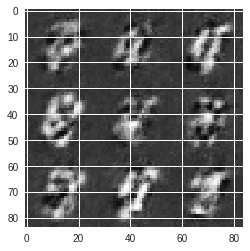

Epoch 1/2... Discriminator Loss: 0.1310... Generator Loss: 2.6198
Epoch 1/2... Discriminator Loss: 0.1693... Generator Loss: 2.3538
Epoch 1/2... Discriminator Loss: 0.0875... Generator Loss: 3.4121
Epoch 1/2... Discriminator Loss: 0.0460... Generator Loss: 4.2025
Epoch 1/2... Discriminator Loss: 0.0891... Generator Loss: 3.2895
Epoch 1/2... Discriminator Loss: 0.0674... Generator Loss: 3.5665
Epoch 1/2... Discriminator Loss: 0.0452... Generator Loss: 4.5145
Epoch 1/2... Discriminator Loss: 0.0491... Generator Loss: 3.9409
Epoch 1/2... Discriminator Loss: 0.0777... Generator Loss: 4.1203
Epoch 1/2... Discriminator Loss: 0.0588... Generator Loss: 3.8876


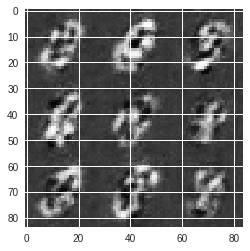

Epoch 1/2... Discriminator Loss: 0.0728... Generator Loss: 3.3593
Epoch 1/2... Discriminator Loss: 0.0633... Generator Loss: 3.4781
Epoch 1/2... Discriminator Loss: 0.0666... Generator Loss: 3.3426
Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 4.0153
Epoch 1/2... Discriminator Loss: 0.0453... Generator Loss: 4.1010
Epoch 1/2... Discriminator Loss: 0.0370... Generator Loss: 4.1966
Epoch 1/2... Discriminator Loss: 0.0688... Generator Loss: 3.3719
Epoch 1/2... Discriminator Loss: 0.0613... Generator Loss: 3.9198
Epoch 1/2... Discriminator Loss: 0.0835... Generator Loss: 3.3443
Epoch 1/2... Discriminator Loss: 0.0678... Generator Loss: 3.9140


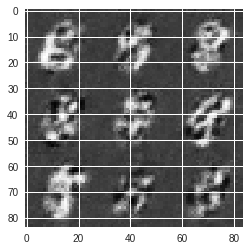

Epoch 1/2... Discriminator Loss: 0.0756... Generator Loss: 3.7030
Epoch 1/2... Discriminator Loss: 0.0530... Generator Loss: 3.3830
Epoch 1/2... Discriminator Loss: 0.0497... Generator Loss: 3.7166
Epoch 1/2... Discriminator Loss: 0.0409... Generator Loss: 4.1652
Epoch 1/2... Discriminator Loss: 0.0601... Generator Loss: 3.5157
Epoch 1/2... Discriminator Loss: 0.0515... Generator Loss: 3.5977
Epoch 1/2... Discriminator Loss: 0.0815... Generator Loss: 3.0054
Epoch 1/2... Discriminator Loss: 0.0365... Generator Loss: 4.2582
Epoch 1/2... Discriminator Loss: 0.0932... Generator Loss: 3.0515
Epoch 1/2... Discriminator Loss: 0.0536... Generator Loss: 3.7664


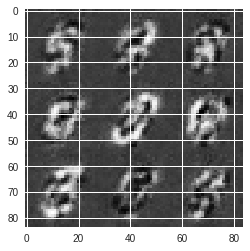

Epoch 1/2... Discriminator Loss: 0.0835... Generator Loss: 3.1335
Epoch 1/2... Discriminator Loss: 0.0394... Generator Loss: 4.1753
Epoch 1/2... Discriminator Loss: 0.0492... Generator Loss: 3.9235
Epoch 1/2... Discriminator Loss: 0.0825... Generator Loss: 3.3686
Epoch 1/2... Discriminator Loss: 0.0554... Generator Loss: 3.7128
Epoch 1/2... Discriminator Loss: 0.0816... Generator Loss: 3.1054
Epoch 1/2... Discriminator Loss: 0.0419... Generator Loss: 4.0304
Epoch 2/2... Discriminator Loss: 0.0373... Generator Loss: 4.0405
Epoch 2/2... Discriminator Loss: 0.0305... Generator Loss: 4.5527
Epoch 2/2... Discriminator Loss: 0.0419... Generator Loss: 3.8224


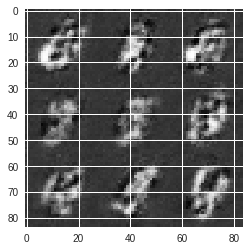

Epoch 2/2... Discriminator Loss: 0.0477... Generator Loss: 3.7792
Epoch 2/2... Discriminator Loss: 0.0486... Generator Loss: 4.2664
Epoch 2/2... Discriminator Loss: 0.0246... Generator Loss: 4.2792
Epoch 2/2... Discriminator Loss: 0.0592... Generator Loss: 3.6536
Epoch 2/2... Discriminator Loss: 0.0485... Generator Loss: 4.1280
Epoch 2/2... Discriminator Loss: 0.0377... Generator Loss: 3.9372
Epoch 2/2... Discriminator Loss: 0.0961... Generator Loss: 3.0027
Epoch 2/2... Discriminator Loss: 0.0559... Generator Loss: 3.6374
Epoch 2/2... Discriminator Loss: 0.0241... Generator Loss: 4.9449
Epoch 2/2... Discriminator Loss: 0.0515... Generator Loss: 4.5643


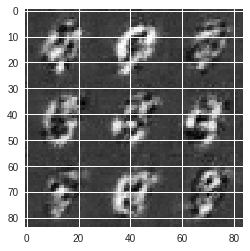

Epoch 2/2... Discriminator Loss: 0.0610... Generator Loss: 3.6816
Epoch 2/2... Discriminator Loss: 0.0346... Generator Loss: 4.1036
Epoch 2/2... Discriminator Loss: 0.0298... Generator Loss: 4.6131
Epoch 2/2... Discriminator Loss: 0.0415... Generator Loss: 4.2241
Epoch 2/2... Discriminator Loss: 0.0457... Generator Loss: 3.9702
Epoch 2/2... Discriminator Loss: 0.0501... Generator Loss: 3.9427
Epoch 2/2... Discriminator Loss: 0.0326... Generator Loss: 4.2584
Epoch 2/2... Discriminator Loss: 0.0596... Generator Loss: 3.7468
Epoch 2/2... Discriminator Loss: 0.0409... Generator Loss: 4.2580
Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 4.3233


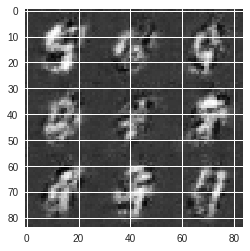

Epoch 2/2... Discriminator Loss: 0.0524... Generator Loss: 3.9050
Epoch 2/2... Discriminator Loss: 0.0372... Generator Loss: 3.9991
Epoch 2/2... Discriminator Loss: 0.0290... Generator Loss: 4.5257
Epoch 2/2... Discriminator Loss: 0.0598... Generator Loss: 3.5382
Epoch 2/2... Discriminator Loss: 0.0438... Generator Loss: 3.8856
Epoch 2/2... Discriminator Loss: 0.0218... Generator Loss: 5.2798
Epoch 2/2... Discriminator Loss: 0.0207... Generator Loss: 4.7410
Epoch 2/2... Discriminator Loss: 0.0232... Generator Loss: 4.4488
Epoch 2/2... Discriminator Loss: 0.0452... Generator Loss: 4.0257
Epoch 2/2... Discriminator Loss: 0.0328... Generator Loss: 4.5094


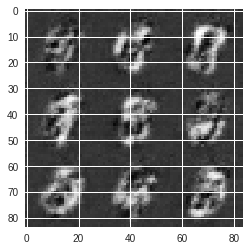

Epoch 2/2... Discriminator Loss: 0.0335... Generator Loss: 4.1690
Epoch 2/2... Discriminator Loss: 0.0432... Generator Loss: 4.1588
Epoch 2/2... Discriminator Loss: 0.0384... Generator Loss: 4.5711
Epoch 2/2... Discriminator Loss: 0.0317... Generator Loss: 4.1260
Epoch 2/2... Discriminator Loss: 0.0528... Generator Loss: 3.7240
Epoch 2/2... Discriminator Loss: 0.0599... Generator Loss: 3.7212
Epoch 2/2... Discriminator Loss: 0.0434... Generator Loss: 4.2003
Epoch 2/2... Discriminator Loss: 0.0393... Generator Loss: 4.7806
Epoch 2/2... Discriminator Loss: 0.0510... Generator Loss: 3.8746
Epoch 2/2... Discriminator Loss: 0.0409... Generator Loss: 4.3547


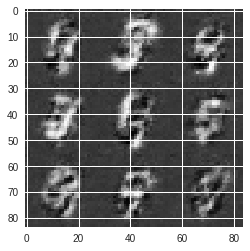

Epoch 2/2... Discriminator Loss: 0.0380... Generator Loss: 3.9626
Epoch 2/2... Discriminator Loss: 0.0339... Generator Loss: 4.6010
Epoch 2/2... Discriminator Loss: 0.0593... Generator Loss: 3.6566
Epoch 2/2... Discriminator Loss: 0.0387... Generator Loss: 4.7923
Epoch 2/2... Discriminator Loss: 0.0533... Generator Loss: 4.2609
Epoch 2/2... Discriminator Loss: 0.0318... Generator Loss: 4.4962
Epoch 2/2... Discriminator Loss: 0.0301... Generator Loss: 4.3356
Epoch 2/2... Discriminator Loss: 0.0631... Generator Loss: 4.2611
Epoch 2/2... Discriminator Loss: 0.0413... Generator Loss: 5.2338
Epoch 2/2... Discriminator Loss: 0.0393... Generator Loss: 4.2389


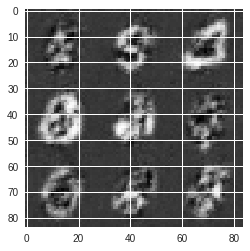

Epoch 2/2... Discriminator Loss: 0.0658... Generator Loss: 3.6631
Epoch 2/2... Discriminator Loss: 0.1927... Generator Loss: 2.1128
Epoch 2/2... Discriminator Loss: 0.0553... Generator Loss: 4.1161
Epoch 2/2... Discriminator Loss: 0.0333... Generator Loss: 5.4741
Epoch 2/2... Discriminator Loss: 0.0297... Generator Loss: 4.9927
Epoch 2/2... Discriminator Loss: 0.0497... Generator Loss: 4.2478
Epoch 2/2... Discriminator Loss: 0.0284... Generator Loss: 4.2828
Epoch 2/2... Discriminator Loss: 0.0446... Generator Loss: 4.5925
Epoch 2/2... Discriminator Loss: 0.0205... Generator Loss: 5.0200
Epoch 2/2... Discriminator Loss: 0.0289... Generator Loss: 4.5652


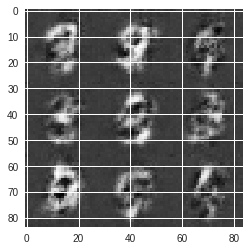

Epoch 2/2... Discriminator Loss: 0.0279... Generator Loss: 4.6453
Epoch 2/2... Discriminator Loss: 0.0446... Generator Loss: 4.1359
Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 4.6829
Epoch 2/2... Discriminator Loss: 0.0433... Generator Loss: 4.4392
Epoch 2/2... Discriminator Loss: 0.3453... Generator Loss: 6.8652
Epoch 2/2... Discriminator Loss: 0.1332... Generator Loss: 5.2992
Epoch 2/2... Discriminator Loss: 0.0871... Generator Loss: 3.8471
Epoch 2/2... Discriminator Loss: 0.0329... Generator Loss: 4.4549
Epoch 2/2... Discriminator Loss: 0.0355... Generator Loss: 4.5988
Epoch 2/2... Discriminator Loss: 0.0351... Generator Loss: 4.3306


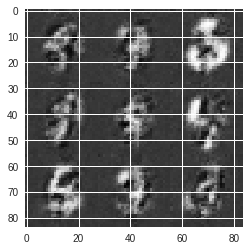

Epoch 2/2... Discriminator Loss: 0.0525... Generator Loss: 4.0861
Epoch 2/2... Discriminator Loss: 0.0478... Generator Loss: 4.3119
Epoch 2/2... Discriminator Loss: 0.0567... Generator Loss: 4.3272
Epoch 2/2... Discriminator Loss: 0.0392... Generator Loss: 4.0278
Epoch 2/2... Discriminator Loss: 0.0443... Generator Loss: 4.2313
Epoch 2/2... Discriminator Loss: 0.0643... Generator Loss: 3.7862
Epoch 2/2... Discriminator Loss: 0.0488... Generator Loss: 3.5728
Epoch 2/2... Discriminator Loss: 0.0697... Generator Loss: 3.5907
Epoch 2/2... Discriminator Loss: 0.0746... Generator Loss: 3.5488
Epoch 2/2... Discriminator Loss: 0.0472... Generator Loss: 4.1754


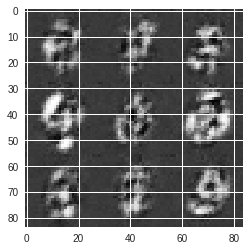

Epoch 2/2... Discriminator Loss: 0.0412... Generator Loss: 4.0682
Epoch 2/2... Discriminator Loss: 0.0406... Generator Loss: 4.1642
Epoch 2/2... Discriminator Loss: 0.0348... Generator Loss: 4.3346
Epoch 2/2... Discriminator Loss: 0.0357... Generator Loss: 4.4200
Epoch 2/2... Discriminator Loss: 0.0513... Generator Loss: 4.1932
Epoch 2/2... Discriminator Loss: 0.0576... Generator Loss: 3.5242
Epoch 2/2... Discriminator Loss: 0.0437... Generator Loss: 4.1749
Epoch 2/2... Discriminator Loss: 0.0538... Generator Loss: 4.1840
Epoch 2/2... Discriminator Loss: 0.0706... Generator Loss: 3.4597
Epoch 2/2... Discriminator Loss: 0.0448... Generator Loss: 4.4113


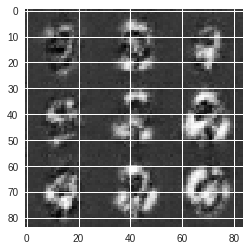

Epoch 2/2... Discriminator Loss: 0.0347... Generator Loss: 4.1312
Epoch 2/2... Discriminator Loss: 0.0390... Generator Loss: 4.0975
Epoch 2/2... Discriminator Loss: 0.0363... Generator Loss: 4.4939
Epoch 2/2... Discriminator Loss: 0.0405... Generator Loss: 4.1171
Epoch 2/2... Discriminator Loss: 0.0487... Generator Loss: 3.7979
Epoch 2/2... Discriminator Loss: 0.0373... Generator Loss: 4.7809
Epoch 2/2... Discriminator Loss: 0.0313... Generator Loss: 4.2472
Epoch 2/2... Discriminator Loss: 0.0471... Generator Loss: 4.3387
Epoch 2/2... Discriminator Loss: 0.0450... Generator Loss: 4.1679
Epoch 2/2... Discriminator Loss: 0.0480... Generator Loss: 3.7618


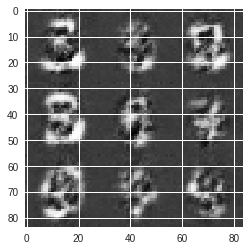

Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 4.0668
Epoch 2/2... Discriminator Loss: 0.0429... Generator Loss: 4.2866
Epoch 2/2... Discriminator Loss: 0.0441... Generator Loss: 4.0138
Epoch 2/2... Discriminator Loss: 0.0407... Generator Loss: 4.3993
Epoch 2/2... Discriminator Loss: 0.0323... Generator Loss: 4.2228
Epoch 2/2... Discriminator Loss: 0.0436... Generator Loss: 4.0703
Epoch 2/2... Discriminator Loss: 0.0248... Generator Loss: 5.2211
Epoch 2/2... Discriminator Loss: 0.0324... Generator Loss: 4.1519
Epoch 2/2... Discriminator Loss: 0.0374... Generator Loss: 4.5903
Epoch 2/2... Discriminator Loss: 0.0338... Generator Loss: 4.3514


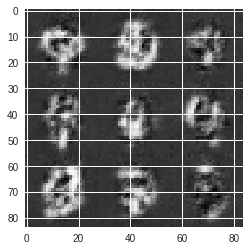

Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 5.0879
Epoch 2/2... Discriminator Loss: 0.0361... Generator Loss: 3.9712
Epoch 2/2... Discriminator Loss: 0.0694... Generator Loss: 3.3470
Epoch 2/2... Discriminator Loss: 0.0344... Generator Loss: 4.3907
Epoch 2/2... Discriminator Loss: 0.0257... Generator Loss: 5.0757
Epoch 2/2... Discriminator Loss: 0.0335... Generator Loss: 4.6281
Epoch 2/2... Discriminator Loss: 0.0244... Generator Loss: 4.8672
Epoch 2/2... Discriminator Loss: 0.0204... Generator Loss: 4.6028
Epoch 2/2... Discriminator Loss: 0.0367... Generator Loss: 4.3024
Epoch 2/2... Discriminator Loss: 0.0121... Generator Loss: 5.1722


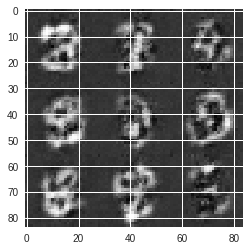

Epoch 2/2... Discriminator Loss: 0.0322... Generator Loss: 4.0932
Epoch 2/2... Discriminator Loss: 0.0201... Generator Loss: 4.7829
Epoch 2/2... Discriminator Loss: 0.0313... Generator Loss: 5.5677
Epoch 2/2... Discriminator Loss: 0.0212... Generator Loss: 4.6930
Epoch 2/2... Discriminator Loss: 0.0454... Generator Loss: 4.1156
Epoch 2/2... Discriminator Loss: 0.0199... Generator Loss: 5.2591
Epoch 2/2... Discriminator Loss: 0.0317... Generator Loss: 4.5080
Epoch 2/2... Discriminator Loss: 0.0313... Generator Loss: 4.1985
Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 4.6994
Epoch 2/2... Discriminator Loss: 0.0357... Generator Loss: 4.3628


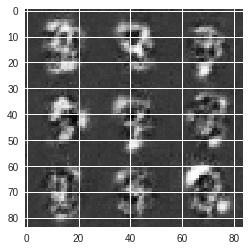

Epoch 2/2... Discriminator Loss: 0.0312... Generator Loss: 4.3148
Epoch 2/2... Discriminator Loss: 0.0374... Generator Loss: 4.4669
Epoch 2/2... Discriminator Loss: 0.0316... Generator Loss: 4.6175
Epoch 2/2... Discriminator Loss: 0.0289... Generator Loss: 4.5268
Epoch 2/2... Discriminator Loss: 0.0408... Generator Loss: 4.1260
Epoch 2/2... Discriminator Loss: 0.0330... Generator Loss: 4.1727
Epoch 2/2... Discriminator Loss: 0.0198... Generator Loss: 5.0015
Epoch 2/2... Discriminator Loss: 0.0271... Generator Loss: 4.6145
Epoch 2/2... Discriminator Loss: 0.0299... Generator Loss: 4.4519
Epoch 2/2... Discriminator Loss: 0.0348... Generator Loss: 4.2182


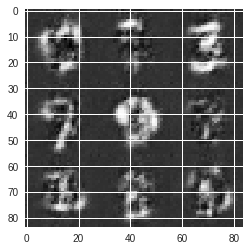

Epoch 2/2... Discriminator Loss: 0.0295... Generator Loss: 4.5578
Epoch 2/2... Discriminator Loss: 0.0338... Generator Loss: 4.6349
Epoch 2/2... Discriminator Loss: 0.0268... Generator Loss: 4.5947
Epoch 2/2... Discriminator Loss: 0.0261... Generator Loss: 4.6539
Epoch 2/2... Discriminator Loss: 0.0319... Generator Loss: 4.2119
Epoch 2/2... Discriminator Loss: 0.0292... Generator Loss: 4.6299
Epoch 2/2... Discriminator Loss: 0.0229... Generator Loss: 4.6418
Epoch 2/2... Discriminator Loss: 0.0193... Generator Loss: 4.9896
Epoch 2/2... Discriminator Loss: 0.0386... Generator Loss: 4.2952
Epoch 2/2... Discriminator Loss: 0.0294... Generator Loss: 4.6918


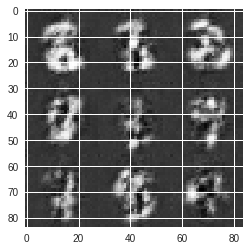

Epoch 2/2... Discriminator Loss: 0.0215... Generator Loss: 4.8598
Epoch 2/2... Discriminator Loss: 0.0202... Generator Loss: 4.9017
Epoch 2/2... Discriminator Loss: 0.0214... Generator Loss: 4.9859
Epoch 2/2... Discriminator Loss: 0.0405... Generator Loss: 4.1455
Epoch 2/2... Discriminator Loss: 0.0404... Generator Loss: 4.4794
Epoch 2/2... Discriminator Loss: 0.0380... Generator Loss: 5.0000
Epoch 2/2... Discriminator Loss: 0.0204... Generator Loss: 5.4669
Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 4.7056
Epoch 2/2... Discriminator Loss: 0.0227... Generator Loss: 5.1071
Epoch 2/2... Discriminator Loss: 0.0235... Generator Loss: 5.0444


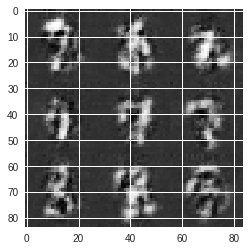

Epoch 2/2... Discriminator Loss: 0.0126... Generator Loss: 5.3086
Epoch 2/2... Discriminator Loss: 0.0300... Generator Loss: 4.7849
Epoch 2/2... Discriminator Loss: 0.0229... Generator Loss: 5.3374
Epoch 2/2... Discriminator Loss: 0.0219... Generator Loss: 5.2126
Epoch 2/2... Discriminator Loss: 0.0183... Generator Loss: 4.6732
Epoch 2/2... Discriminator Loss: 0.0206... Generator Loss: 5.0616
Epoch 2/2... Discriminator Loss: 0.0362... Generator Loss: 4.2292
Epoch 2/2... Discriminator Loss: 0.0175... Generator Loss: 4.9593
Epoch 2/2... Discriminator Loss: 0.0106... Generator Loss: 5.3471
Epoch 2/2... Discriminator Loss: 0.0181... Generator Loss: 5.3027


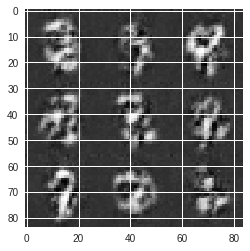

Epoch 2/2... Discriminator Loss: 0.0365... Generator Loss: 4.5751
Epoch 2/2... Discriminator Loss: 0.0381... Generator Loss: 3.9457
Epoch 2/2... Discriminator Loss: 0.1363... Generator Loss: 2.6957
Epoch 2/2... Discriminator Loss: 0.0198... Generator Loss: 5.1655
Epoch 2/2... Discriminator Loss: 0.0123... Generator Loss: 5.6519
Epoch 2/2... Discriminator Loss: 0.0224... Generator Loss: 4.8315
Epoch 2/2... Discriminator Loss: 0.0192... Generator Loss: 5.2906
Epoch 2/2... Discriminator Loss: 0.0215... Generator Loss: 4.9048
Epoch 2/2... Discriminator Loss: 0.0288... Generator Loss: 4.5446
Epoch 2/2... Discriminator Loss: 0.0327... Generator Loss: 4.4824


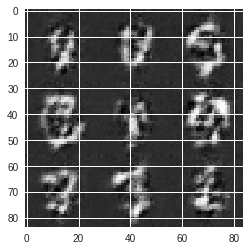

Epoch 2/2... Discriminator Loss: 0.0353... Generator Loss: 4.5773
Epoch 2/2... Discriminator Loss: 0.0220... Generator Loss: 4.4895
Epoch 2/2... Discriminator Loss: 0.0120... Generator Loss: 5.6802
Epoch 2/2... Discriminator Loss: 0.0283... Generator Loss: 4.4268
Epoch 2/2... Discriminator Loss: 0.0216... Generator Loss: 5.1249


In [35]:
batch_size = 32
z_dim = 100
learning_rate = 0.00002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 1.3768


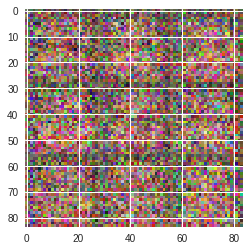

Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 1.6295
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 1.4868
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 1.6197
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 1.4487
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.3967


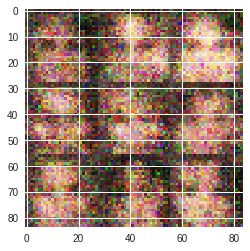

Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.3279
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 1.6286
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 1.6160
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 1.7741
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 1.7791
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 1.5209


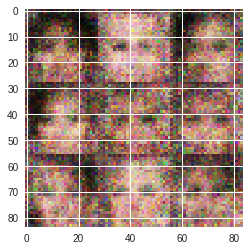

Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 1.5783
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 1.6040
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 1.4971
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 1.6666
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 1.5235
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.4218


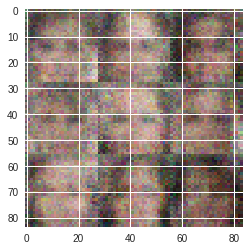

Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.5155
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8888


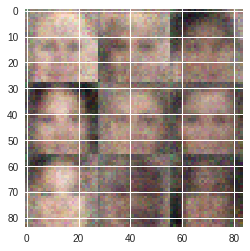

Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.8945


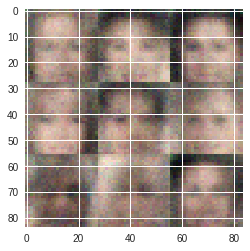

Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.1086


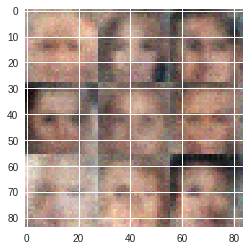

Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0808


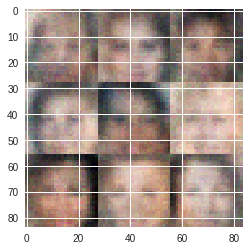

Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9662


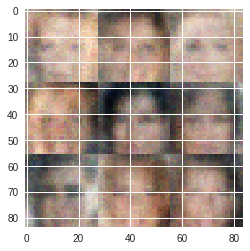

Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.1335


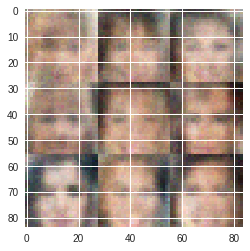

Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.2549


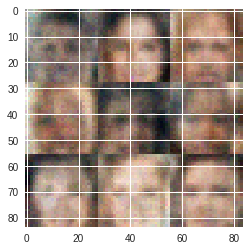

Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.0023


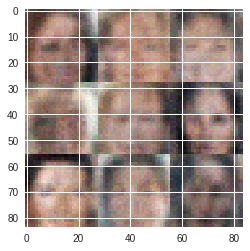

Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.4005
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.9391


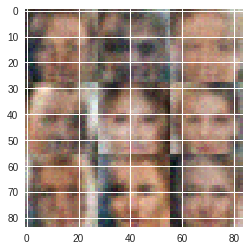

Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 1.7375
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.9499


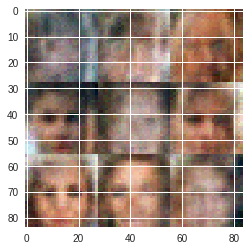

Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.0794


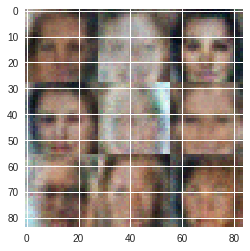

Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 1.3801


In [36]:
batch_size = 128
z_dim = 100
learning_rate =  0.00002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.